[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/kan-bayashi/INTERSPEECH19_TUTORIAL/blob/master/notebooks/wavenet_vocoder/wavenet_vocoder.ipynb)

# WaveNet Vocoder Recipe Demonstration

**Tomoki Hayashi**

Department of Informatics, Nagoya University  
Human Dataware Lab. Co., Ltd.

Good afternoon, everyone.  
This is Tomoki Hayashi, doctoral researcher @ Nagoya university.  
From here, I will introduce my implementation of wavenet vocoder.

## Access the notebook

https://bit.ly/2kqDCEr

<img src=https://user-images.githubusercontent.com/22779813/64497216-2154e180-d2e7-11e9-861a-7987af223fd0.png width=30%>

If you have not yet open the notebook, please access the notebook from this colab URL.  
You can also access from the my github.

In [1]:
import time
start_time = time.time()

## Environmental setup

First, install dependecies (It takes several minutes).

First, let us setup the environment.  
Please run the cell and please wait a minute until finish the installation.

In [2]:
!apt-get install -qq -y bc tree
!git clone https://github.com/kan-bayashi/PytorchWaveNetVocoder.git -b IS19TUTORIAL
!git clone https://github.com/k2kobayashi/sprocket.git -b IS19TUTORIAL
!cd sprocket && pip install -q .
!cd PytorchWaveNetVocoder && pip install -q .
!cd PytorchWaveNetVocoder && mkdir -p tools/venv/bin && touch tools/venv/bin/activate
import sprocket, wavenet_vocoder  # check importable
!echo "Setup done!"

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
Cloning into 'PytorchWaveNetVocoder'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 2268 (delta 182), reused 214 (delta 147), pack-reused 1998
Receiving objects: 100% (2268/2268), 425.58 KiB | 304.00 KiB/s, done.
Resolving deltas: 100% (1398/1398), done.
Checking connectivity... done.
Cloning into 'sprocket'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 3092 (delta 61), reused 63 (delta 30), pack-reused 2985
Receiving objects: 100% (3092/3092), 1.74 MiB | 666.00 KiB/s, done.
Resolving deltas: 100% (2000/2000), done.
Checking connectivity... done.
Setup done!


## What is the PytorchWaveNetVocoder?

Github: [kan-bayashi/PytorchWaveNetVocoder](https://github.com/kan-bayashi/PytorchWaveNetVocoder)  
Samples: https://kan-bayashi.github.io/WaveNetVocoderSamples/

- WaveNet vocoder implemention with pytorch
- Support [kaldi](https://github.com/kaldi-asr/kaldi)-like recipes, easy to reproduce the results
- Support [World](https://github.com/mmorise/World) features / mel-spectrogram based models
- Support multi-gpu training / decoding
- Support a noise shaping [[Tachibana+ 2018](https://ieeexplore.ieee.org/document/8461332)]




During the installation, let me introduce my implementation of wavenet vocoder, named pytorch wavenet vocoder.  
You can check the code from my github and listen to the sample in the demo HP.  
This repository provides the wavenet vocoder implementation using pytorch.  
And it supports kaldi-like recipe, easy to reproduce the results.
And support speech analyzer, world-based feature and mel-spectrogram based models.  
So you can use this repository for not only voice conversion but also text-to-speech.  
And it also supports multi-gpu training / decoding, and noise shaping techniques proposed by Tachibana.

## What it the kaldi-like recipe?

Key features:
- Prepared for each corpus (e.g. CMU Arctic, LJSpeech)
- Consists of unified several stages  
  (e.g. data preparation, feature extraction, and so on.)
- Includes all procedures needed to reproduce the results
- All of the recipes are stored in `egs/<corpus>/<type>`.

Maybe the most of you are familiar with kaldi, so here let me introduce kaldi-like recipe briefly.  
Kaldi-like recipes are prepared for each corpus such as CMU Arctic, LJspeech.  
These recipes consist of unified several stages, including data download, preparation, feature extraction, training and so on.  
In other words, each recipe includes all of the procedures which needed to reproduce the results.  
All of the recipes are stored in egs / the name of corpus / the type of recipe.

Supported corpus:
- [CMUArctic database](http://www.festvox.org/cmu_arctic/): `egs/arctic`, 16 kHz, English, Several speakers.
- [LJ Speech database](https://keithito.com/LJ-Speech-Dataset/): `egs/ljspeech` 22.05 kHz, English, Single female speaker.
- [M-AILABS speech database](http://www.m-ailabs.bayern/en/the-mailabs-speech-dataset/):`egs/m-ailabs-speech`: 16 kHz, various speakers

About supported type, see detail in https://github.com/kan-bayashi/PytorchWaveNetVocoder/tree/master/egs

Here is the list of supported corpus.
CMU Arctic, LJSpeech, M-AILABS Speech dataset.
About the supported recipe type, please check the URL.

Of course you can add your own recipe using your own corpus.  
After this demonstration, maybe you can understand how to apply your dataset to make recipe.

## Run the demo recipe

Let us run the demo recipe `egs/arctic/sd-mini`.

- Small version of `egs/arctic/sd`
- Use subset of all of the utterances
- **Cannot build a good model** but the flow is **the same**

You can understand each stage within 30 minutes!

OK. Maybe you finished the installation.  
Let us start the running the recipe.  
In this demonstration, we use egs/arctic/sd-mini recipe, which is a small version of sd reicpe.  
It uses subset of all of the utterances and unfortunately cannot build a good model but the flow is the completely same.  
You can understand each stage within 30 minutes.  
Let move on the recipe directory. Please run the cell.

In [3]:
# move on the recipe directory
import os
os.chdir("./PytorchWaveNetVocoder/egs/arctic/sd-mini")
!echo $(pwd)

/work5/t_hayashi/work/is18_tutorial/notebooks/wavenet_vocoder/PytorchWaveNetVocoder/egs/arctic/sd-mini


Files in the recipe are as follows:
- `conf`: Directory including config files
- `path.sh`: Script to set the environmental variables.
- `run.sh`: Main script.

In [4]:
!tree -L 1

.
├── conf
├── path.sh
└── run.sh

1 directory, 2 files


First, I will introduce the files included in the recipe directory.  
Let me check the files.  
Conf is the directory including config files, path.sh is the script ot set the environmental variable such as CUDA, and run.sh is the main script.

`conf` includes f0 setting files whose name format is `<speaker_name>.f0`.

In [5]:
!ls conf

awb.f0	bdl.f0	clb.f0	jmk.f0	ksp.f0	rms.f0	slt.f0


Let me check the files in the conf directory.  
conf includes f0 setting files whose name format is speaker_name.f0.

`<speaker_name>.f0` includes `min_f0 max_f0`.  
These values are predecided by ourselve, so you can modify them.

In [6]:
!cat conf/slt.f0  # (minf0 maxf0)

120 275


conf includes f0 setting files whose name format is <speaker_name>.f0.  
These files are used for world feature extraction.  
And each <speaker_name>.f0 includes min_f0 and max_f0 values.  
These values are predecided by ourselve, so you can modify them.

All of the hyperparameters are written in `run.sh`.

In [7]:
!head -n 69 run.sh 

#!/bin/bash
############################################################
#         DEMO SCRIPT TO BUILD SD WAVENET VOCODER          #
############################################################

# Copyright 2017 Tomoki Hayashi (Nagoya University)
#  Apache 2.0  (http://www.apache.org/licenses/LICENSE-2.0)

. ./path.sh || exit 1;

# USER SETTINGS {{{
#######################################
#           STAGE SETTING             #
#######################################
stage=0123456
# 0: data preparation step
# 1: feature extraction step
# 2: statistics calculation step
# 3: noise weighting step
# 4: training step
# 5: decoding step
# 6: noise shaping step

#######################################
#          FEATURE SETTING            #
#######################################
feature_type=world     # world or melspc (in this recipe fixed to "world")
spk=slt                # target spekaer in arctic
minf0=""               # minimum f0 (if not set, conf/*.f0 will be used)
maxf0=""         

Let us introduce these parameters in detail later.

All of the hyperparameters are written in the main script run.sh.
Let me check the all of the hyperparameters.  
These parameters can be changed from command line. of course you can directly edit the file.  
Each of hyperparameters is explained in detail later.

In [8]:
# (Optional) here you can add your command to check the file!


### Overview of the recipe

<div align="center">
    <img src=figs/overview.png width=80%>
</div>

OK. Let us move ont the introduction of the flow of the recipe.  
This figure is the overview of recipe.  
The recipe consists of 7 stages from 0 to 6.  
In stage 0, the corpus will be donwloaded from cloud and then split the corpus into training and evaluation set.  
Stage 1 performs preprocessing and feature extraction.  
Stage 2 calculates the statistics of extracted features.  
Stage 3 performs noise weighting for training waveforms.  
Stage 4 trains WaveNet using extracted features and noise weighted waveforms.  
Stage 5 decodes waveform of evaluation data using trained WaveNet.  
And finaly, Stage 6 perform noise shaping for generated waveforms.

If run `run.sh`, all of stages will be performed.

But we can specify the stage to run with `--stage` options.

- `run.sh --stage 0`: Run only the stage 0
- `run.sh --stage 012`: Run the stages 0, 1, and 2.

Here, let us run each stage step-by-step.

If you run the main script run.sh, all of the above stages will be performed.  
But we can specify the stage to be running with --stage option like this.  
Here, to understand each stage, let us run each stage step-by-step.

### Stage 0: Data preparation

This stage performs download of corpus and list preparation.

<div align="center">
    <img src=figs/stage_0.png width=70%>
</div>

First, stage 0, data prepration.  
This stage downloads corpus from cloud and make the list of utterances.

In arctic, there are seven speakers.  
Here let us use `slt` to build a model.

In [9]:
# you can specify the speaker via --spk (default=slt)
!./run.sh --stage 0 --spk slt

###########################################################
#                 DATA PREPARATION STEP                   #
###########################################################
--2019-09-12 16:24:54--  https://drive.google.com/uc?export=download&id=1NIia89CL2qqqDzNNc718wycRmI_jkLxR
Resolving drive.google.com (drive.google.com)... 172.217.161.238, 2404:6800:400a:80c::200e
Connecting to drive.google.com (drive.google.com)|172.217.161.238|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-08-30-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f6hb8l88c0ejiuv1kacg12qful95rg0g/1568268000000/04214513489132088126/*/1NIia89CL2qqqDzNNc718wycRmI_jkLxR?e=download [following]
--2019-09-12 16:24:57--  https://doc-08-30-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/f6hb8l88c0ejiuv1kacg12qful95rg0g/1568268000000/04214513489132088126/*/1NIia89CL2qqqDzNNc718wycRmI_jkLxR?e=download
Resolving doc-0

cmu_us_rms_arctic_mini/wav/arctic_a0008.wav
cmu_us_rms_arctic_mini/wav/arctic_a0009.wav
cmu_us_rms_arctic_mini/wav/arctic_a0010.wav
cmu_us_rms_arctic_mini/wav/arctic_a0011.wav
cmu_us_rms_arctic_mini/wav/arctic_a0012.wav
cmu_us_rms_arctic_mini/wav/arctic_a0013.wav
cmu_us_rms_arctic_mini/wav/arctic_a0014.wav
cmu_us_rms_arctic_mini/wav/arctic_a0015.wav
cmu_us_rms_arctic_mini/wav/arctic_a0016.wav
cmu_us_rms_arctic_mini/wav/arctic_a0017.wav
cmu_us_rms_arctic_mini/wav/arctic_a0018.wav
cmu_us_rms_arctic_mini/wav/arctic_a0019.wav
cmu_us_rms_arctic_mini/wav/arctic_a0020.wav
cmu_us_rms_arctic_mini/wav/arctic_a0021.wav
cmu_us_rms_arctic_mini/wav/arctic_a0022.wav
cmu_us_rms_arctic_mini/wav/arctic_a0023.wav
cmu_us_rms_arctic_mini/wav/arctic_a0024.wav
cmu_us_rms_arctic_mini/wav/arctic_a0025.wav
cmu_us_rms_arctic_mini/wav/arctic_a0026.wav
cmu_us_rms_arctic_mini/wav/arctic_a0027.wav
cmu_us_rms_arctic_mini/wav/arctic_a0028.wav
cmu_us_rms_arctic_mini/wav/arctic_a0029.wav
cmu_us_rms_arctic_mini/wav/arcti

In arctic, seven speakers exists.  
Here let us use female speaker slt to build a model.  
You can specify the speaker with `--spk` option.  
Please run the cell.

Corpus is saved in
- `downloads/cmu_us_<spk_name>_arctic_mini`

Two lists of wav files are created.
- `data/tr_slt/wav.scp`: wav list file for training
- `data/ev_slt/wav.scp`: wav list file for evaluation

In [10]:
!tree -L 3 -I local

.
├── conf
│   ├── awb.f0
│   ├── bdl.f0
│   ├── clb.f0
│   ├── jmk.f0
│   ├── ksp.f0
│   ├── rms.f0
│   └── slt.f0
├── data
│   ├── ev_slt
│   │   └── wav.scp
│   └── tr_slt
│       └── wav.scp
├── downloads
│   ├── cmu_us_awb_arctic_mini
│   │   └── wav
│   ├── cmu_us_bdl_arctic_mini
│   │   └── wav
│   ├── cmu_us_clb_arctic_mini
│   │   └── wav
│   ├── cmu_us_jmk_arctic_mini
│   │   └── wav
│   ├── cmu_us_ksp_arctic_mini
│   │   └── wav
│   ├── cmu_us_rms_arctic_mini
│   │   └── wav
│   ├── cmu_us_slt_arctic_mini
│   │   └── wav
│   └── COPYING
├── path.sh
└── run.sh

19 directories, 12 files


Let me check the file. Please run the cell.  
The downloaded corpus is saved in downloads/cmu_us_.  
And 2 lists of wav files are created under the data directory.  
data/tr_slt/wav.scp is for training and the other is for evaluation.

The list file is that:
- Each line has the path of wav file
- All of the lines are sorted

In [11]:
 !head -n 3 data/*_slt/wav.scp

==> data/ev_slt/wav.scp <==
downloads/cmu_us_slt_arctic_mini/wav/arctic_b0092.wav
downloads/cmu_us_slt_arctic_mini/wav/arctic_b0228.wav
downloads/cmu_us_slt_arctic_mini/wav/arctic_b0435.wav

==> data/tr_slt/wav.scp <==
downloads/cmu_us_slt_arctic_mini/wav/arctic_a0001.wav
downloads/cmu_us_slt_arctic_mini/wav/arctic_a0002.wav
downloads/cmu_us_slt_arctic_mini/wav/arctic_a0003.wav


Here we use 32 utts for training, 4 for evaluation.

In [12]:
!wc -l < data/tr_slt/wav.scp
!wc -l < data/ev_slt/wav.scp

32
4


Let me check the list file format. Please run the cell.  
You can see that each line has the path of wav file and all of the lines are sorted.  
Let me check the number of lines via wc commnd.  
Here we use 32 utterances for training and 4 utterances for evalaution.

In [13]:
# (Optional) here you can check the file with your commands!


### Stage 1: Feature extraction

This stage performs feature extraction with the
list file.

<div align="center">
    <img src=figs/stage_1.png width=70%>
</div>

Next, stage 1 feature extration.  
This stage applies high pass filter as preprocessing and then extract feature vector using world analyzer.

In [14]:
# Hyperparameters related to stage 1
!head -n 36 run.sh | tail -n 13

#######################################
#          FEATURE SETTING            #
#######################################
feature_type=world     # world or melspc (in this recipe fixed to "world")
spk=slt                # target spekaer in arctic
minf0=""               # minimum f0 (if not set, conf/*.f0 will be used)
maxf0=""               # maximum f0 (if not set, conf/*.f0 will be used)
shiftms=5              # shift length in msec
fftl=1024              # fft length
highpass_cutoff=70     # highpass filter cutoff frequency (if 0, will not apply)
fs=16000               # sampling rate
mcep_dim=24            # dimension of mel-cepstrum
mcep_alpha=0.410       # alpha value of mel-cepstrum


At first, let me check the hyperparameters related to feature extraction.

In [15]:
# run stage 1 with default settings
!./run.sh --stage 1

###########################################################
#               FEATURE EXTRACTION STEP                   #
###########################################################
09/12/2019 04:25:01 (feature_extract:343) INFO: waveforms = data/tr_slt/wav.scp
09/12/2019 04:25:01 (feature_extract:343) INFO: hdf5dir = hdf5/tr_slt
09/12/2019 04:25:01 (feature_extract:343) INFO: wavdir = wav_hpf/tr_slt
09/12/2019 04:25:01 (feature_extract:343) INFO: fs = 16000
09/12/2019 04:25:01 (feature_extract:343) INFO: shiftms = 5.0
09/12/2019 04:25:01 (feature_extract:343) INFO: feature_type = world
09/12/2019 04:25:01 (feature_extract:343) INFO: mspc_dim = 80
09/12/2019 04:25:01 (feature_extract:343) INFO: minf0 = 120
09/12/2019 04:25:01 (feature_extract:343) INFO: maxf0 = 275
09/12/2019 04:25:01 (feature_extract:343) INFO: mcep_dim = 24
09/12/2019 04:25:01 (feature_extract:343) INFO: mcep_alpha = 0.41
09/12/2019 04:25:01 (feature_extract:343) INFO: fftl = 1024
09/12/2019 04:25:01 (feature_extract:3

Please run the stage 1.  
In the log, they show the hyperparameters and progress.  
And this stage is performed in parallel using the multiprocessing.

Hyperparameters can be changed via command line.  
But it will overwrite the existing ones. Be careful.

In [16]:
# example of changing hyperparameters of feature extraction
# !./run.sh --stage 1 --mcep_dim 30 --shiftms 10 

If you want to change the hyperparameters of feature extraction, we can change by specifiying the option from command line.  
But the feature vector will be overwritten, please be careful.

Extracted features are saved as `hdf5` in
- `hdf5/tr_slt/*.h5`: Feature file of training data 
- `hdf5/ev_slt/*.h5`: Feature file of evaluation data

Lists of feature files are created 
- `data/tr_slt/feats.scp`
- `data/ev_slt/feats.scp`

High pass filtered training wav files are saved in
- `wav_hpf/tr_slt/*.wav`: Filtered wav file of training data

List of filetered wav files is created
- `data/tr_slt/wav_hpf.scp`: List of filtered wav files

In [17]:
!tree -L 3 -I "*.f0|local|cmu_*"

.
├── conf
├── data
│   ├── ev_slt
│   │   ├── feats.scp
│   │   └── wav.scp
│   └── tr_slt
│       ├── feats.scp
│       ├── wav_hpf.scp
│       └── wav.scp
├── downloads
│   └── COPYING
├── exp
│   └── feature_extract
│       ├── feature_extract_ev_slt.log
│       └── feature_extract_tr_slt.log
├── hdf5
│   ├── ev_slt
│   │   ├── arctic_b0092.h5
│   │   ├── arctic_b0228.h5
│   │   ├── arctic_b0435.h5
│   │   └── arctic_b0454.h5
│   └── tr_slt
│       ├── arctic_a0001.h5
│       ├── arctic_a0002.h5
│       ├── arctic_a0003.h5
│       ├── arctic_a0004.h5
│       ├── arctic_a0005.h5
│       ├── arctic_a0006.h5
│       ├── arctic_a0007.h5
│       ├── arctic_a0008.h5
│       ├── arctic_a0009.h5
│       ├── arctic_a0010.h5
│       ├── arctic_a0011.h5
│       ├── arctic_a0012.h5
│       ├── arctic_a0013.h5
│       ├── arctic_a0014.h5
│       ├── arctic_a0015.h5
│       ├── arctic_a0016.h5
│       ├── arctic_a0017.h5
│       ├── arctic_a0018.h5
│       ├── arctic_a0019.h5
│       ├── arctic_

OK. Let me check the created files.  
Extracted features are saved in the hdf5 format under hdf5 directory.  
hdf5/tr_slt includes feature files for training and hdf5/ev_lst includes oens for evaluation.  
Also lists of these feature vector are created under data directory.
data/tr_slt/feats.scp and data/ev_slt/feats.scp.

And for training data, high pass filetered waveform is saved uder wav_hpf directory.  
The list of filtered wav files is also created. 

Let us check the list file format:
- Each line has the path of feature or wav
file  
- All of the lines are sorted
- Assume that all of the lists has the same
order

In [18]:
!head -n 3 data/*_slt/feats.scp
!echo ""
!head -n 3 data/tr_slt/wav_hpf.scp

==> data/ev_slt/feats.scp <==
hdf5/ev_slt/arctic_b0092.h5
hdf5/ev_slt/arctic_b0228.h5
hdf5/ev_slt/arctic_b0435.h5

==> data/tr_slt/feats.scp <==
hdf5/tr_slt/arctic_a0001.h5
hdf5/tr_slt/arctic_a0002.h5
hdf5/tr_slt/arctic_a0003.h5

wav_hpf/tr_slt/arctic_a0001.wav
wav_hpf/tr_slt/arctic_a0002.wav
wav_hpf/tr_slt/arctic_a0003.wav


Let me check the format of list files.  
As the same as wav.scp files, each line has the path of feature or wav file, and all of the lines are sorted.  
We assume that all of the lists has the same order.

hdf5 format can be loaded as `numpy.ndarray` in python using `h5py` library.

In [19]:
import h5py
with h5py.File("hdf5/tr_slt/arctic_a0001.h5") as f:
    print(f.keys())
    feat = f["world"][()]
# or you can use our utils
from wavenet_vocoder.utils import read_hdf5
feat = read_hdf5("hdf5/tr_slt/arctic_a0001.h5", "world")
print("Feature shape: (#num_frames=%d, #feature_dims=%d)" % (feat.shape[0], feat.shape[1]))

<KeysViewHDF5 ['world']>
Feature shape: (#num_frames=672, #feature_dims=28)


/home/t_hayashi/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  


The extracted hdf5 file can be loaded as numpy.ndarray using h5py.   
Here we load the feature via h5py.  
Also we provide the utilities tool read_hdf5.  
You can use this instead of h5py library.

The feature is extracted with World.
- `U/V binary` (1 dim)
- `continuous F0` (1 dim), 
- `mcep`(25 dim = `mcep_dim + 1`) 
- `ap` (1 dim).

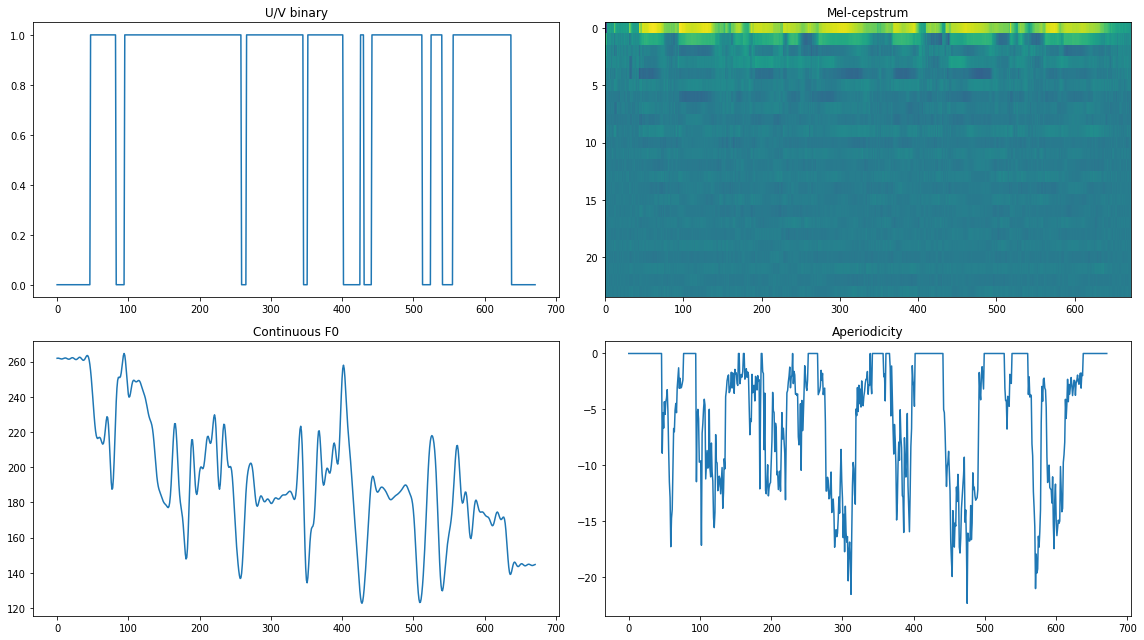

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 9))
plt.subplot(2, 2, 1)
plt.plot(feat[:, 0])
plt.title("U/V binary")
plt.subplot(2, 2, 3)
plt.plot(feat[:, 1])
plt.title("Continuous F0")
plt.subplot(2, 2, 2)
plt.imshow(feat[:, 2:26].T, aspect="auto")
plt.title("Mel-cepstrum")
plt.subplot(2, 2, 4)
plt.plot(feat[:, -1])
plt.title("Aperiodicity")
plt.tight_layout()
plt.show()

The dimenstion of feature vector is 28.  
Let me check each components of feature vector.  
The feature is extracted with World analyzer.  
Let me visualize each features.
U/V binary, contious F0, mel-ceptrum, and aperiodicity components.

In [21]:
# (Optional) here you can check the file with your commands!


### Stage 2: Statistics calculation

This stage calculates the mean and variance of features.

<div align="center">
    <img src=figs/stage_2.png width=70%>
</div>

Next, stage 2 statistics calculation.  
This stage calculate the mean and variacne of features for feature normalization and filtering.

In [22]:
# run stage 2 with default settings
!./run.sh --stage 2

###########################################################
#              CALCULATE STATISTICS STEP                  #
###########################################################
09/12/2019 04:25:07 (calc_stats:77) INFO: feats = data/tr_slt/feats.scp
09/12/2019 04:25:07 (calc_stats:77) INFO: stats = data/tr_slt/stats.h5
09/12/2019 04:25:07 (calc_stats:77) INFO: feature_type = world
09/12/2019 04:25:07 (calc_stats:77) INFO: verbose = 1
09/12/2019 04:25:07 (calc_stats:81) INFO: number of utterances = 32
09/12/2019 04:25:07 (calc_stats:25) INFO: now processing hdf5/tr_slt/arctic_a0001.h5 (1/32)
09/12/2019 04:25:07 (calc_stats:25) INFO: now processing hdf5/tr_slt/arctic_a0002.h5 (2/32)
09/12/2019 04:25:07 (calc_stats:25) INFO: now processing hdf5/tr_slt/arctic_a0003.h5 (3/32)
09/12/2019 04:25:07 (calc_stats:25) INFO: now processing hdf5/tr_slt/arctic_a0004.h5 (4/32)
09/12/2019 04:25:07 (calc_stats:25) INFO: now processing hdf5/tr_slt/arctic_a0005.h5 (5/32)
09/12/2019 04:25:07 (calc_stats:

Please run the stage 2.

Calculated statistics are saved as `hdf5` format in
- `data/tr_slt/stats.h5`

`stats.h5` is used for:
- Feature normalization during training
- Calculation of noise shaping filter coefficient

In [23]:
!tree -L 3 -I "*.f0|*.wav|*[0-9].h5|local|cmu_*"

.
├── conf
├── data
│   ├── ev_slt
│   │   ├── feats.scp
│   │   └── wav.scp
│   └── tr_slt
│       ├── feats.scp
│       ├── stats.h5
│       ├── wav_hpf.scp
│       └── wav.scp
├── downloads
│   └── COPYING
├── exp
│   ├── calculate_statistics
│   │   └── calc_stats_tr_slt.log
│   └── feature_extract
│       ├── feature_extract_ev_slt.log
│       └── feature_extract_tr_slt.log
├── hdf5
│   ├── ev_slt
│   └── tr_slt
├── path.sh
├── run.sh
└── wav_hpf
    └── tr_slt

13 directories, 12 files


Through the stage 2, statistics file is saved as hdf5 format under the data/tr_slt.  
Let me check the files.  
`stats.h5` is the statistics of the training data.  
`stats.h5` is used for feature normalization during training and calculation of noise shaping coefficient.  

`stats.h5` can be loaded as follows:

In [24]:
with h5py.File("data/tr_slt/stats.h5") as f:
    print(f.keys())
    print(f['world'].keys())
    mean = f['world']['mean'][()]
    scale = f['world']['scale'][()]
    print(mean.shape)
    print(scale.shape)
    
# or you use our utils
mean = read_hdf5("data/tr_slt/stats.h5", "world/mean")
scale = read_hdf5("data/tr_slt/stats.h5", "world/scale")

<KeysViewHDF5 ['world']>
<KeysViewHDF5 ['mean', 'scale']>
(28,)
(28,)


/home/t_hayashi/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


Let me load the statistics file.  
It contains mean and scale, which is a variance.

In [25]:
# here you can check the file with your commands!


### Stage 3: Noise weighting

This stage applies noise weighting filter to training
wav files.

<div align="center">
    <img src=figs/stage_3.png width=70%>
</div>

Next, stage 3, noise weighting.  
This stage applies noise weighting filter to high pass filtered wav files.

In [26]:
# Hyperparameters related to stage 3
!head -n 38 run.sh | tail -n 2

use_noise_shaping=true # whether to use noise shaping
mag=0.5                # strength of noise shaping (0.0 < mag <= 1.0)


Let me check the hyperparameters related to stage 3.  
The hyperparametres are onlly use_noise_shaping which decides whether to perform noise shapng, 
and mag, which is the strength value from 0.0 to 1.0.  
Experimentaly around 0.5 is a good for the best quality.  
You can see the detail investigation in Dr. Tachibana's paper.

In [27]:
# run stage 3 with default settings
!./run.sh --stage 3

###########################################################
#                  NOISE WEIGHTING STEP                   #
###########################################################
09/12/2019 04:25:09 (noise_shaping:154) INFO: waveforms = data/tr_slt/wav_hpf.scp
09/12/2019 04:25:09 (noise_shaping:154) INFO: stats = data/tr_slt/stats.h5
09/12/2019 04:25:09 (noise_shaping:154) INFO: outdir = wav_nwf/tr_slt
09/12/2019 04:25:09 (noise_shaping:154) INFO: fs = 16000
09/12/2019 04:25:09 (noise_shaping:154) INFO: shiftms = 5.0
09/12/2019 04:25:09 (noise_shaping:154) INFO: feature_type = world
09/12/2019 04:25:09 (noise_shaping:154) INFO: mcep_dim_start = 2
09/12/2019 04:25:09 (noise_shaping:154) INFO: mcep_dim_end = 27
09/12/2019 04:25:09 (noise_shaping:154) INFO: mcep_alpha = 0.41
09/12/2019 04:25:09 (noise_shaping:154) INFO: mag = 0.5
09/12/2019 04:25:09 (noise_shaping:154) INFO: verbose = 1
09/12/2019 04:25:09 (noise_shaping:154) INFO: n_jobs = 10
09/12/2019 04:25:09 (noise_shaping:154) INFO

If `use_noise_shaping=false`, `stage 3` will be skipped.

Please run the stage 3.  
Note that if you specify use_noise_shaping = false, this stage will be skipped.

Noise weighting filtered wav files are saved in
- `wav_nwf/tr_slt/*.wav`

The list of noise weighting filtered wav files is saved as
- `data/tr_slt/wav_nwf.scp`

In [28]:
!tree -L 3 -I "*.f0|*[0-9].h5|local|cmu_*"

.
├── conf
├── data
│   ├── ev_slt
│   │   ├── feats.scp
│   │   └── wav.scp
│   └── tr_slt
│       ├── feats.scp
│       ├── stats.h5
│       ├── wav_hpf.scp
│       ├── wav_nwf.scp
│       └── wav.scp
├── downloads
│   └── COPYING
├── exp
│   ├── calculate_statistics
│   │   └── calc_stats_tr_slt.log
│   ├── feature_extract
│   │   ├── feature_extract_ev_slt.log
│   │   └── feature_extract_tr_slt.log
│   └── noise_shaping
│       └── noise_shaping_apply_tr_slt.log
├── hdf5
│   ├── ev_slt
│   └── tr_slt
├── path.sh
├── run.sh
├── wav_hpf
│   └── tr_slt
│       ├── arctic_a0001.wav
│       ├── arctic_a0002.wav
│       ├── arctic_a0003.wav
│       ├── arctic_a0004.wav
│       ├── arctic_a0005.wav
│       ├── arctic_a0006.wav
│       ├── arctic_a0007.wav
│       ├── arctic_a0008.wav
│       ├── arctic_a0009.wav
│       ├── arctic_a0010.wav
│       ├── arctic_a0011.wav
│       ├── arctic_a0012.wav
│       ├── arctic_a0013.wav
│       ├── arctic_a0014.wav
│       ├── arctic_a0015.wav
│    

Let me chech the created files.   
Noise weighting filtered wav files are saved in wav_nwf/tr_slt.  
The list of noise weighting filtered wav files is saved as data/tr_slt/wav_nwf.scp  

Let us check the difference of waveform here.

In [29]:
# listen to the samples
import IPython.display
IPython.display.display(IPython.display.Audio("wav_hpf/tr_slt/arctic_a0001.wav"))
IPython.display.display(IPython.display.Audio("wav_nwf/tr_slt/arctic_a0001.wav"))

Text(0.5, 1.0, 'Noise weighting filtered spectrogram')

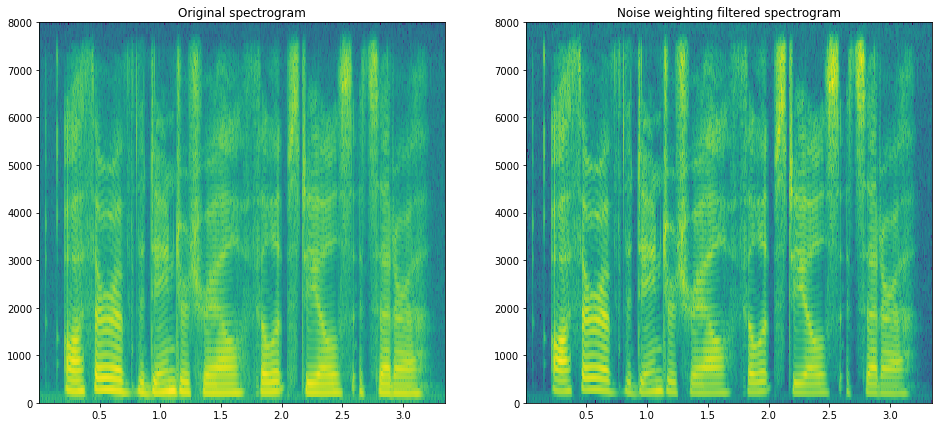

In [30]:
# show spectrogram
import soundfile as sf
import matplotlib.pyplot as plt
x, fs = sf.read("wav_hpf/tr_slt/arctic_a0001.wav")
x_ns, fs = sf.read("wav_nwf/tr_slt/arctic_a0001.wav")
plt.figure(figsize=(16, 7))
plt.subplot(1, 2, 1)
plt.specgram(x, Fs=fs)
plt.title("Original spectrogram")
plt.subplot(1, 2, 2)
plt.specgram(x_ns, Fs=fs)
plt.title("Noise weighting filtered spectrogram")  

Here, let me check the difference.  
Please run the cell.  
Maybe you can understand the difference between them.  
Let me also check the spectrogram. Please run the cell.
You can confirm that the power in highfreqency became bigger and that in low frequency did smaller.

Filtering related parameters `mlas/coef` and `mlsa/alpha` are added in `data/tr_slt/stats.h5`.

In [31]:
with h5py.File("data/tr_slt/stats.h5") as f:
    print(f.keys())
    print(f["mlsa"].keys())
    print(f["mlsa"]["alpha"])
    print(f["mlsa"]["coef"])

<KeysViewHDF5 ['mlsa', 'world']>
<KeysViewHDF5 ['alpha', 'coef']>
<HDF5 dataset "alpha": shape (), type "<f8">
<HDF5 dataset "coef": shape (25,), type "<f8">


/home/t_hayashi/.pyenv/versions/3.6.4/lib/python3.6/site-packages/ipykernel_launcher.py:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  """Entry point for launching an IPython kernel.


`mlsa/coef` is the coefficient of MLSA filter, which is calculated from averaged mel-cepstrum and `mag`.  
`mlsa/alpha` is the hyperparameter `alpha`, all pass filter coefficient.

And through this stage, additional parameters are written in the statistics file `stats.h5`.  
Let me check added parameters.  
One is the mlsa/coef, which is the coefficient of MLSA fileter.  
They are calculated from averated mel-ceptrum and mag parameters, as you saw in the Dr. Toda's lecture.  
The other is the mlsa/alpha, which the all pass filter coefficient.  
These parameters are used in the final stage, noise shaping.

In [32]:
# (Optional) here you can check the file with your commands!


### Stage 4: WaveNet training

This stage trains WaveNet using extracted
features and noise weighting filtered wav files.

<div align="center">
    <img src=figs/stage_4.png width=70%>
</div>

I'm sorry I kept you waiting.  Now ready to train the network!  
Next is the stage 4, WaveNet training.

In [33]:
# Hyperparameters related to stage 4
!head -n 59 run.sh | tail -n 19

#######################################
#          TRAINING SETTING           #
#######################################
n_gpus=1                # number of gpus
n_quantize=256          # number of quantization of waveform
n_aux=28                # number of auxiliary features
n_resch=32              # number of residual channels
n_skipch=16             # number of skip channels
dilation_depth=5        # dilation depth (e.g. if set 10, max dilation = 2^(10-1))
dilation_repeat=1       # number of dilation repeats
kernel_size=2           # kernel size of dilated convolution
lr=1e-4                 # learning rate
weight_decay=0.0        # weight decay coef
iters=1000              # number of iterations
batch_length=10000      # batch length
batch_size=1            # batch size
checkpoint_interval=100 # save model per this number
use_upsampling=true     # whether to use upsampling layer
resume=""               # checkpoint path to resume (Optional)


First, please run the cell to check the hyperparameters.  
There are several parameters related to network structure, and the others are realted to training.  
I will explain in later.

In [34]:
# run stage 4 with default settings
!./run.sh --stage 4 --iters 500

###########################################################
#               WAVENET TRAINING STEP                     #
###########################################################
'data/tr_slt/stats.h5' -> 'exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/stats.h5'
09/12/2019 04:25:12 (train:413) INFO: waveforms = data/tr_slt/wav_nwf.scp
09/12/2019 04:25:12 (train:413) INFO: feats = data/tr_slt/feats.scp
09/12/2019 04:25:12 (train:413) INFO: stats = data/tr_slt/stats.h5
09/12/2019 04:25:12 (train:413) INFO: expdir = exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up
09/12/2019 04:25:12 (train:413) INFO: feature_type = world
09/12/2019 04:25:12 (train:413) INFO: n_quantize = 256
09/12/2019 04:25:12 (train:413) INFO: n_aux = 28
09/12/2019 04:25:12 (train:413) INFO: n_resch = 32
09/12/2019 04:25:12 (train:413) INFO: n_skipch = 16
09/12/2019 04:25:12 (train:413) INFO: dilation_depth = 5
09/12/2019

Please run the stage 4.  Here we train 500 iteration by specifying the hyperparameters iters=500.

Default network structure in `egs/arctic/sd-mini`.
<div align="center">
    <img src=figs/wavenet.png width=70%>
</div>

During the training, I will explain the relationship between the hyperparameters and network structure.  
This figure shows the wavenet structure.  
The hyperparameters related to network structure are 
- n_aux, which is the number of auxiliary features
- n_resch. which is the number of channel in convoluional layer placed in residual blocks,
- n_skipch, which is the number of channles in convolutional layer connected to output layers.
- n_quantize, which is the number of classes of discretized wavenform,
In my implementation, we use one-hot vector formated waveform as a inputs.

Maybe you can understand the relationship between the hyperparameters and the structure.

Example when `dilation_depth=3` and `dilation_repeat=2`.

<div align="center">
    <img src=figs/structure_ex.png width=45%>
</div>

Remaining hyperparameters related to the structure are dilation_depth and dilation_repeat.  
I will explain these parameters using the example.  
This figure shows the example of diation_depth=3 and dilation_repeat=2.  
The number of residual blocks is equal to dilation depth times dilation repeat, in this case the number of blocks is 6.  
Each of dilation in each residual block starts from 2 to the power of 0, 2 to the power of 1, 2 to the power 2 and then repeat them.

Make a batch by split a waveform into pieces.
- `batch_size`: Number of batches
- `batch_length`: Length of each batch

<div align="center">
    <img src=figs/batch.png width=65%>
</div>

Next, I will explain how to make the batch.
This figure shows the overview of batch making.    
The batch will be created in the windowing manner.
batch_length decides the length of each piece and batch_size decides the number of pieces.  
The length of each piece is batch_length + receptive field size and the next batch will be created with receptive_filed size overlap.  
This is because we do not calculate the loss for corresponding to within receptive fields.  
OK. Maybe you finished the training. Let me check the results.

Model parameters are saved as  
- `exp/tr_arctic_16k_sd_world_slt_*/checkpoint-*.pkl` 

Modle configuration is saved as  
- `exp/tr_arctic_16k_sd_world_slt_*/model.conf`

The directory name is automatically set to be unique depending on hyperparameters.

In [35]:
!tree -L 3 -I "*.f0|*.wav|*[0-9].h5|*.scp|*.log|local|cmu_*"

.
├── conf
├── data
│   ├── ev_slt
│   └── tr_slt
│       └── stats.h5
├── downloads
│   └── COPYING
├── exp
│   ├── calculate_statistics
│   ├── feature_extract
│   ├── noise_shaping
│   └── tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up
│       ├── checkpoint-100.pkl
│       ├── checkpoint-200.pkl
│       ├── checkpoint-300.pkl
│       ├── checkpoint-400.pkl
│       ├── checkpoint-500.pkl
│       ├── checkpoint-final.pkl
│       ├── log
│       ├── model.conf
│       └── stats.h5
├── hdf5
│   ├── ev_slt
│   └── tr_slt
├── path.sh
├── run.sh
├── wav_hpf
│   └── tr_slt
└── wav_nwf
    └── tr_slt

18 directories, 12 files


Let us check the files. please run the cell.  
Model parameters are saved in exp/tr_buraburabura/checkpoint.pkl  and model configuration file is saved as model.conf in the same directory.  
The name of the directory is automatically set o be unique depending on hyperparameters.  
So if you change the hyperparemeters, the model will be saved in the different directory,  
You do not need to care about the overwriting.  
The log is also saved in log directory in the same directory.

Model configuration file can be loaded as `argparse.Namespace`.

In [36]:
import torch
conf = torch.load("exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/model.conf")
print(conf)

Namespace(batch_length=10000, batch_size=1, checkpoint_interval=100, dilation_depth=5, dilation_repeat=1, expdir='exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up', feats='data/tr_slt/feats.scp', feature_type='world', intervals=100, iters=500, kernel_size=2, lr=0.0001, n_aux=28, n_gpus=1, n_quantize=256, n_resch=32, n_skipch=16, resume='', seed=1, stats='data/tr_slt/stats.h5', upsampling_factor=80, use_speaker_code=False, use_upsampling_layer=1, verbose=1, waveforms='data/tr_slt/wav_nwf.scp', weight_decay=0.0)


Here, let me load the model.conf in python.  
This file can be loaded using pytorch load function and then loaded as Namespace like this.  
It contains the hyperparemters to build the network.

Model parameters `checkpoint-*.pkl` can be loaded as `dict` which contains
following information:
- `iterations`: Number of iterations of this parameters
- `optimizer`: `Dict` of states of optimizer
- `model`: `OrderedDict` of Model
parameters

In [37]:
state_dict = torch.load("exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/checkpoint-500.pkl")
print(state_dict.keys())
print(state_dict["iterations"])
print(state_dict["optimizer"].keys())
print(state_dict["model"].keys())

dict_keys(['model', 'optimizer', 'iterations'])
500
dict_keys(['state', 'param_groups'])
odict_keys(['causal.conv.weight', 'causal.conv.bias', 'upsampling.conv.weight', 'upsampling.conv.bias', 'dil_sigmoid.0.conv.weight', 'dil_sigmoid.0.conv.bias', 'dil_sigmoid.1.conv.weight', 'dil_sigmoid.1.conv.bias', 'dil_sigmoid.2.conv.weight', 'dil_sigmoid.2.conv.bias', 'dil_sigmoid.3.conv.weight', 'dil_sigmoid.3.conv.bias', 'dil_sigmoid.4.conv.weight', 'dil_sigmoid.4.conv.bias', 'dil_tanh.0.conv.weight', 'dil_tanh.0.conv.bias', 'dil_tanh.1.conv.weight', 'dil_tanh.1.conv.bias', 'dil_tanh.2.conv.weight', 'dil_tanh.2.conv.bias', 'dil_tanh.3.conv.weight', 'dil_tanh.3.conv.bias', 'dil_tanh.4.conv.weight', 'dil_tanh.4.conv.bias', 'aux_1x1_sigmoid.0.weight', 'aux_1x1_sigmoid.0.bias', 'aux_1x1_sigmoid.1.weight', 'aux_1x1_sigmoid.1.bias', 'aux_1x1_sigmoid.2.weight', 'aux_1x1_sigmoid.2.bias', 'aux_1x1_sigmoid.3.weight', 'aux_1x1_sigmoid.3.bias', 'aux_1x1_sigmoid.4.weight', 'aux_1x1_sigmoid.4.bias', 'aux_1x

Let me load the model parameter file checkpoint.pkl. Please run the cell.  
This file contains the number of iteration, optimizer states, and model parameters.  

You can resume training from `checkpoint-*.pkl` file with `--resume` options.

In [38]:
!./run.sh --stage 4 \
    --iters 1000 \
    --resume exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/checkpoint-500.pkl

###########################################################
#               WAVENET TRAINING STEP                     #
###########################################################
09/12/2019 04:25:36 (train:413) INFO: waveforms = data/tr_slt/wav_nwf.scp
09/12/2019 04:25:36 (train:413) INFO: feats = data/tr_slt/feats.scp
09/12/2019 04:25:36 (train:413) INFO: stats = data/tr_slt/stats.h5
09/12/2019 04:25:36 (train:413) INFO: expdir = exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up
09/12/2019 04:25:36 (train:413) INFO: feature_type = world
09/12/2019 04:25:36 (train:413) INFO: n_quantize = 256
09/12/2019 04:25:36 (train:413) INFO: n_aux = 28
09/12/2019 04:25:36 (train:413) INFO: n_resch = 32
09/12/2019 04:25:36 (train:413) INFO: n_skipch = 16
09/12/2019 04:25:36 (train:413) INFO: dilation_depth = 5
09/12/2019 04:25:36 (train:413) INFO: dilation_repeat = 1
09/12/2019 04:25:36 (train:413) INFO: kernel_size = 2
09/12/2019 04:25:36 (train:413) 

So you can resume the training from checkpoint file.  
Here, let us resume the training from 500 iters checkpoint and then continue to train until 1000 iters.

You can train using multi-gpu with `--n_gpus` option.

In [39]:
# In colab, we can use only a single gpu :(
# batch_size must be >= n_gpus
# !./run.sh --stage 4 --n_gpus 2 --batch_size 2

Also, if you want to use multi gpu, please use n_gpus options.  
Note that please set batch_size to be greater than or equal to n_gpus in the case of multi gpus.  
Unfortunately, we cannot use multi gpu so skipped it.

In [40]:
# here you can check the file with your commands!


### Stage 5: WaveNet decoding

This stage performs decoding of evaluation data.

<div align="center">
    <img src=figs/stage_5.png width=70%>
</div>

Next, stage 5, WaveNet training.  
This stage performs decoding using evaluation set features.

In [41]:
# Hyperparameters related to stage 5
!head -n 69 run.sh | tail -n 9

#######################################
#          DECODING SETTING           #
#######################################
outdir=""           # directory to save decoded wav dir (Optional)
checkpoint=""       # checkpoint path to be used for decoding (Optional)
config=""           # model configuration path (Optional)
stats=""            # statistics path (Optional)
feats=""            # list or directory of feature files (Optional)
decode_batch_size=4 # batch size in decoding


Let me check the hyperparameters related to stage 5.  
Please run the cell.  

(After running training)  
There are some hyperparameters to specifying the model to be used.  
If you not provide these hyperparameters, the script will use checkpoint-final.pkl corresponding to specfied hyperparameters.  
So the important one is the decode_batch_size.  
In this implementation, decoding is performed in batch mode, it can reduce the generation time.  
But it requires GPU memory. So if you want to generated very long utterances, please be careful to avoid out of memory error.

In [42]:
# run stage 5 with default setting
!./run.sh --stage 5

###########################################################
#               WAVENET DECODING STEP                     #
###########################################################
09/12/2019 04:25:54 (decode:223) INFO: feats = data/ev_slt/feats.scp
09/12/2019 04:25:54 (decode:223) INFO: checkpoint = exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/checkpoint-final.pkl
09/12/2019 04:25:54 (decode:223) INFO: outdir = exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/wav
09/12/2019 04:25:54 (decode:223) INFO: stats = exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/stats.h5
09/12/2019 04:25:54 (decode:223) INFO: config = exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/model.conf
09/12/2019 04:25:54 (decode:223) INFO: fs = 16000
09/12/2019 04:25:54 (decode:223) INFO: batch_size = 4
09/12/2019 04:25:54

Before the explanation of hyperparameters, let us run the stage 5.  
It takes time. please keep waiting.

You can specify the `checkpoint-*.pkl` file used for decoding and directory to
be saved via `--checkpoint` and `--outdir` options.

In [43]:
# it takes times, comment out
# !./run.sh --stage 5 \
#     --checkpoint exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/checkpoint-100.pkl
#     --outdir exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/wav_ckpt_100

For example, you can specify the model parameter file to be used for decoding like this.  
It takes time, we skip it.  

We can use multi-gpu decoding via `--n_gpus` option.

In [44]:
# In colab, we can use only a single gpu :(
# !./run.sh --stage 5 --n_gpus 2

Also, we can perform multi-gpu decoding.  you can use --n_gpus options like this but does not work in colab.

### MOS on Naturalness

<img src=https://camo.githubusercontent.com/b1b752447f3d040901fae34fefca03fc0765d187/68747470733a2f2f6b616e2d626179617368692e6769746875622e696f2f576176654e6574566f636f64657253616d706c65732f696d616765732f6d6f735f6e756d5f747261696e2e626d70 width=70%>

This figure shows the result of MOS on naturalness.  
Vertical axis represents MOS on naturalness and horizon one represents the type of model.  
The number in the brackets represents the number of utterances of training data.  
From this figure, we can build a good sd wavenet vocoder if we parepare greater than 300 uttrances. 

Generated wav files are saved in 
- `exp/tr_arctic_sd_tr_arctic_16k_sd_*/wav`

In [45]:
!tree exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up

exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up
├── checkpoint-1000.pkl
├── checkpoint-100.pkl
├── checkpoint-200.pkl
├── checkpoint-300.pkl
├── checkpoint-400.pkl
├── checkpoint-500.pkl
├── checkpoint-600.pkl
├── checkpoint-700.pkl
├── checkpoint-800.pkl
├── checkpoint-900.pkl
├── checkpoint-final.pkl
├── log
│   └── tr_slt.log
├── model.conf
├── stats.h5
└── wav
    ├── arctic_b0092.wav
    ├── arctic_b0228.wav
    ├── arctic_b0435.wav
    ├── arctic_b0454.wav
    └── log
        └── decode.log

3 directories, 19 files


OK. I hope we finsh the decoding.  
Let me check the generated wav files. please run the cell.  
Generated wav files are saved in the wav directory located in the model directory.  
These wav files are based on the noise weighting filtered one, so we need to restore to original waveform scale.  

In [46]:
# (Optional) here you can check the file with your commands!


### Stage 6: Noise shaping

This stage applies noise shaping filter to generated wav files.

<div align="center">
    <img src=figs/stage_6.png width=70%>
</div>

OK. The next stage is the final.  
Stage 6, noise shaping.  
This stage applies noise shaping filter, which is the inverse filter of noise weighting filter, to generated wav files to restore them into original scale.

In [47]:
# run stage 6 with default setting
!./run.sh --stage 6

###########################################################
#                  NOISE SHAPING STEP                     #
###########################################################
09/12/2019 04:27:19 (noise_shaping:154) INFO: waveforms = exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/wav/wav.scp
09/12/2019 04:27:19 (noise_shaping:154) INFO: stats = exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/stats.h5
09/12/2019 04:27:19 (noise_shaping:154) INFO: outdir = exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/wav_nsf
09/12/2019 04:27:19 (noise_shaping:154) INFO: fs = 16000
09/12/2019 04:27:19 (noise_shaping:154) INFO: shiftms = 5.0
09/12/2019 04:27:19 (noise_shaping:154) INFO: feature_type = world
09/12/2019 04:27:19 (noise_shaping:154) INFO: mcep_dim_start = 2
09/12/2019 04:27:19 (noise_shaping:154) INFO: mcep_dim_end = 27
09/12/2019 04:27:19 

Please run the stage 6.

Restored wav files are saved in

- `exp/tr_arctic_sd_tr_arctic_16k_sd_*/wav_nsf`

In [48]:
!tree exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up

exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up
├── checkpoint-1000.pkl
├── checkpoint-100.pkl
├── checkpoint-200.pkl
├── checkpoint-300.pkl
├── checkpoint-400.pkl
├── checkpoint-500.pkl
├── checkpoint-600.pkl
├── checkpoint-700.pkl
├── checkpoint-800.pkl
├── checkpoint-900.pkl
├── checkpoint-final.pkl
├── log
│   └── tr_slt.log
├── model.conf
├── stats.h5
├── wav
│   ├── arctic_b0092.wav
│   ├── arctic_b0228.wav
│   ├── arctic_b0435.wav
│   ├── arctic_b0454.wav
│   ├── log
│   │   └── decode.log
│   └── wav.scp
└── wav_nsf
    ├── arctic_b0092.wav
    ├── arctic_b0228.wav
    ├── arctic_b0435.wav
    └── arctic_b0454.wav

4 directories, 24 files


Restored wav fiels are saved in wav_nsf directory located in the model directory.  
Let me check the files.

In [49]:
# (Optional) here you can check the file with your commands!


Finished! Unfortunately, generated samples are just-like a noise.  
So Let us check the samples which trained with `egs/arctic/sd` from  
https://kan-bayashi.github.io/WaveNetVocoderSamples/

## Use pretrained model as vocoder

Here we show how-to-use pretrained model as
vocoder.  
What we need to prepare is following three files:

- `model.conf`:
Model configuration file.
- `checkpoint-*.pkl`: Model parameter file.
- `stats.h5`: Statistics file.

Let us pack following files into
`pretrained_model/` directory.

In [50]:
# summarize trained model in the directory
!mkdir pretrained_model
!cp -v exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/stats.h5 \
    exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/model.conf \
    exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/checkpoint-1000.pkl \
    pretrained_model

'exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/stats.h5' -> 'pretrained_model/stats.h5'
'exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/model.conf' -> 'pretrained_model/model.conf'
'exp/tr_arctic_16k_sd_world_slt_nq256_na28_nrc32_nsc16_ks2_dp5_dr1_lr1e-4_wd0.0_bl10000_bs1_ns_up/checkpoint-1000.pkl' -> 'pretrained_model/checkpoint-1000.pkl'


First, please prepare the list file of feature files to be decoded.

In [51]:
import os
import numpy as np

# here make a dummy features and the stored as hdf5 with key "/world"
os.makedirs("dummy", exist_ok=True)
for idx, n_frames in enumerate([10, 20, 30, 40]): 
    x = np.random.randn(n_frames, 28)  # (#num_frames, #feature_dims)
    with h5py.File("dummy/dummy_%d.h5" % idx, "w") as f:
        f["world"] = x

# make a list of features to be decoded.
!find dummy -name "*.h5" > dummy_feats.scp

# check
!cat dummy_feats.scp

dummy/dummy_0.h5
dummy/dummy_1.h5
dummy/dummy_2.h5
dummy/dummy_3.h5


Run the `--stage 56` by specifying `--feats` in the recipe directory.

In [52]:
# decode with pretrained model through the recipe
!./run.sh --stage 56 \
    --outdir dummy_feats_wav \
    --feats dummy_feats.scp \
    --checkpoint pretrained_model/checkpoint-1000.pkl
!ls dummy_feats_wav*

###########################################################
#               WAVENET DECODING STEP                     #
###########################################################
09/12/2019 04:27:22 (decode:223) INFO: feats = dummy_feats.scp
09/12/2019 04:27:22 (decode:223) INFO: checkpoint = pretrained_model/checkpoint-1000.pkl
09/12/2019 04:27:22 (decode:223) INFO: outdir = dummy_feats_wav
09/12/2019 04:27:22 (decode:223) INFO: stats = pretrained_model/stats.h5
09/12/2019 04:27:22 (decode:223) INFO: config = pretrained_model/model.conf
09/12/2019 04:27:22 (decode:223) INFO: fs = 16000
09/12/2019 04:27:22 (decode:223) INFO: batch_size = 4
09/12/2019 04:27:22 (decode:223) INFO: n_gpus = 1
09/12/2019 04:27:22 (decode:223) INFO: intervals = 1000
09/12/2019 04:27:22 (decode:223) INFO: seed = 1
09/12/2019 04:27:22 (decode:223) INFO: verbose = 1
09/12/2019 04:27:27 (decode:314) INFO: decoding start
09/12/2019 04:27:30 (wavenet:483) INFO: 1000/3199 estimated time = 6.969 sec (0.003 sec / sa

If you want to use outside of the recipe, directly call python scripts stored in
`wavenet_vocoder/bin`.

In [53]:
# decode with pretrained model
!python ../../../wavenet_vocoder/bin/decode.py \
     --feats dummy_feats.scp \
     --outdir dummy_feats_wav_2 \
     --checkpoint pretrained_model/checkpoint-1000.pkl \
     --fs 16000 \
     --n_gpus 1 \
     --batch_size 4
# make list of wav files to be filtered
!find dummy_feats_wav_2 -name "*.wav" > dummy_feats_wav_2/wav.scp
# apply noise shaping filter
!python ../../../wavenet_vocoder/bin/noise_shaping.py \
     --waveforms dummy_feats_wav_2/wav.scp \
     --outdir dummy_feats_wav_2_nsf \
     --stats pretrained_model/stats.h5 \
     --fs 16000 \
     --shiftms 5
!ls dummy_feats_wav_2*

09/12/2019 04:27:39 (decode:223) INFO: feats = dummy_feats.scp
09/12/2019 04:27:39 (decode:223) INFO: checkpoint = pretrained_model/checkpoint-1000.pkl
09/12/2019 04:27:39 (decode:223) INFO: outdir = dummy_feats_wav_2
09/12/2019 04:27:39 (decode:223) INFO: stats = None
09/12/2019 04:27:39 (decode:223) INFO: config = None
09/12/2019 04:27:39 (decode:223) INFO: fs = 16000
09/12/2019 04:27:39 (decode:223) INFO: batch_size = 4
09/12/2019 04:27:39 (decode:223) INFO: n_gpus = 1
09/12/2019 04:27:39 (decode:223) INFO: intervals = 1000
09/12/2019 04:27:39 (decode:223) INFO: seed = 1
09/12/2019 04:27:39 (decode:223) INFO: verbose = 1
09/12/2019 04:27:44 (decode:314) INFO: decoding start
09/12/2019 04:27:47 (wavenet:483) INFO: 1000/3199 estimated time = 7.309 sec (0.003 sec / sample)
09/12/2019 04:27:50 (wavenet:483) INFO: 2000/3199 estimated time = 3.786 sec (0.003 sec / sample)
09/12/2019 04:27:53 (wavenet:483) INFO: 3000/3199 estimated time = 0.615 sec (0.003 sec / sample)
09/12/2019 04:27:54 

## Combine with Sprocket

Let us show how-to-combine wavenet vocoder with voice conversion toolkit [sprocket](https://github.com/k2kobayashi/sprocket).    
Here, we generate converted voice with pretrained models.

Oh time is limited, we skip the usage of pretrained model part.  
Let's move on the final part, combine with sprocket.  
This part is corresponding to the final recipe 3, explain Dr. Kobayashi slides.

In this part, we show how to combine wavenet vocoder with voice conversion toolkit sprocket.  
We try to generated voice with pretrained models.

In [54]:
# changed directory
!mkdir ../../../../conversion_example
os.chdir("../../../../conversion_example")
!pwd

/work5/t_hayashi/work/is18_tutorial/notebooks/wavenet_vocoder/conversion_example


First, let us move on the directory.

First, download pretrained models.

In [55]:
# download sprocket model
!../PytorchWaveNetVocoder/wavenet_vocoder/utils/download_from_google_drive.sh \
    "https://drive.google.com/open?id=1PiGDyYDQt0b4h6KAV1MOmDxHjHUv1cT6" \
    downloads/sprocket_pretrained

# download wavenet vocoder model
!../PytorchWaveNetVocoder/wavenet_vocoder/utils/download_from_google_drive.sh \
    "https://drive.google.com/open?id=1AhtRB0vTkjDrum-dfgaiXnQgsAAiYMGW" \
    downloads/wavenet_vocoder_pretrained

# download wav samples
!../PytorchWaveNetVocoder/wavenet_vocoder/utils/download_from_google_drive.sh \
    "https://drive.google.com/open?id=1kBwF7ejyCR5aI9FitmMSCnWdPCNVouqg"

--2019-09-12 16:27:56--  https://drive.google.com/uc?export=download&id=1PiGDyYDQt0b4h6KAV1MOmDxHjHUv1cT6
Resolving drive.google.com (drive.google.com)... 172.217.161.238, 2404:6800:400a:80c::200e
Connecting to drive.google.com (drive.google.com)|172.217.161.238|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-14-30-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tt5881nchs738cho0o5q5e8bm13vooj0/1568268000000/04214513489132088126/*/1PiGDyYDQt0b4h6KAV1MOmDxHjHUv1cT6?e=download [following]
--2019-09-12 16:27:58--  https://doc-14-30-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/tt5881nchs738cho0o5q5e8bm13vooj0/1568268000000/04214513489132088126/*/1PiGDyYDQt0b4h6KAV1MOmDxHjHUv1cT6?e=download
Resolving doc-14-30-docs.googleusercontent.com (doc-14-30-docs.googleusercontent.com)... 172.217.26.97, 2404:6800:400a:808::2001
Connecting to doc-14-30-docs.googleusercontent.com (doc-14-30-docs

Here let us download sprocket pretrained model, and wavenet vocoder pretrained model, and sample speech for the inputs.

- Sprocket pretrained model
    - `GMM_mcep.pkl`: GMM param file for mcep conversion.
    - `<src_spk>.yml`: Source speaker yaml file.
    - `<src_spk>-<tar_spk>.yml`: Source-target speaker pair yaml file.
    - `<src_spk>.h5`: Statistics file of source speaker.
    - `<tar_spk>.h5`: Statistics file of target speaker.
    - `cvgv.h5`: Statistics file of global variance for converted features.
    
- Target speaker WaveNet vocoder pretrained model
    - `model.conf`: Model configuration file.
    - `checkpoint-*.pkl`: Model parameter file.
    - `stats.h5`: Statistics file.

In [56]:
!ls downloads/*pretrained

downloads/sprocket_pretrained:
cvgv.h5  GMM_codeap.pkl  GMM_mcep.pkl  rms.h5  rms-slt.yml  rms.yml  slt.h5

downloads/wavenet_vocoder_pretrained:
checkpoint-final.pkl  model.conf  stats.h5


Let me check the downloaded pretrained models.  
Sprocket model includes ...  
And wavenet vocoder model includes ...

Next, extract features and then convert them to target speaker's one.  

In [57]:
![ ! -e hdf5 ] && mkdir hdf5
![ ! -e wav ] && mkdir wav
!PYTHONPATH=../sprocket/example/src \
    python ../sprocket/sprocket/bin/convert_feats.py \
        --cvmcep0th True \
        --cvcodeap True \
        --cvgvstats downloads/sprocket_pretrained/cvgv.h5 \
        --org_yml downloads/sprocket_pretrained/rms.yml \
        --pair_yml downloads/sprocket_pretrained/rms-slt.yml \
        --org_stats downloads/sprocket_pretrained/rms.h5 \
        --tar_stats downloads/sprocket_pretrained/slt.h5 \
        --mcepgmmf downloads/sprocket_pretrained/GMM_mcep.pkl \
        --iwav downloads/samples/src/arctic_b0536.wav \
        --cvfeats hdf5/arctic_b0536.h5 \
        --owav wav/arctic_b0536.wav
!ls hdf5 wav

/home/t_hayashi/.pyenv/versions/3.6.4/lib/python3.6/site-packages/sklearn/base.py:306: UserWarning: Trying to unpickle estimator GaussianMixture from version 0.21.2 when using version 0.21.3. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
GMM for mcep conversion mode: None
hdf5:
arctic_b0536.h5

wav:
arctic_b0536.wav


Next, extract features and then convert them to target speaker's one.  
Input waveform is specified by `--iwav` and then converted feats are saved as `--cvfeats`, vocoded waveform is saved as `--owav`.
Converted feature vector is saved in hdf5 directory, and converted voice with vocoder is saved in wav.

Then generate waveform with pretrained wavenet using converted features.

In [58]:
# NOTE: require too much time.
# decode with wavenet vocoder
!find hdf5 -name "*.h5" > hdf5/feats.scp
!python ../PytorchWaveNetVocoder/wavenet_vocoder/bin/decode.py \
     --feats hdf5/feats.scp \
     --outdir wav_wnv \
     --checkpoint downloads/wavenet_vocoder_pretrained/checkpoint-final.pkl \
     --fs 16000 \
     --n_gpus 1 \
     --batch_size 4
# apply noise shaping filter
!find wav_wnv -name "*.wav" > wav_wnv/wav.scp
!python ../PytorchWaveNetVocoder/wavenet_vocoder/bin/noise_shaping.py \
     --waveforms wav_wnv/wav.scp \
     --outdir wav_wnv_nsf \
     --stats downloads/wavenet_vocoder_pretrained/stats.h5 \
     --fs 16000 \
     --shiftms 5

09/12/2019 04:28:12 (decode:223) INFO: feats = hdf5/feats.scp
09/12/2019 04:28:12 (decode:223) INFO: checkpoint = downloads/wavenet_vocoder_pretrained/checkpoint-final.pkl
09/12/2019 04:28:12 (decode:223) INFO: outdir = wav_wnv
09/12/2019 04:28:12 (decode:223) INFO: stats = None
09/12/2019 04:28:12 (decode:223) INFO: config = None
09/12/2019 04:28:12 (decode:223) INFO: fs = 16000
09/12/2019 04:28:12 (decode:223) INFO: batch_size = 4
09/12/2019 04:28:12 (decode:223) INFO: n_gpus = 1
09/12/2019 04:28:12 (decode:223) INFO: intervals = 1000
09/12/2019 04:28:12 (decode:223) INFO: seed = 1
09/12/2019 04:28:12 (decode:223) INFO: verbose = 1
09/12/2019 04:28:17 (decode:314) INFO: decoding start
09/12/2019 04:28:34 (wavenet:483) INFO: 1000/33919 estimated time = 536.048 sec (0.016 sec / sample)
09/12/2019 04:28:50 (wavenet:483) INFO: 2000/33919 estimated time = 507.947 sec (0.016 sec / sample)
09/12/2019 04:29:06 (wavenet:483) INFO: 3000/33919 estimated time = 498.443 sec (0.016 sec / sample)
0

And then let us generate with wavenet vocoder!  
You can run this cell but it takes time.  
So we have put pre-generated ones in `samples`.  
Let us listen to them.

In [59]:
# listen to pre-synthesized ones
import IPython.display
print("Source")
IPython.display.display(IPython.display.Audio("downloads/samples/src/arctic_b0536.wav"))
print("Target")
IPython.display.display(IPython.display.Audio("downloads/samples/tar/arctic_b0536.wav"))
print("Converted voice with vocoder")
IPython.display.display(IPython.display.Audio("downloads/samples/vocoder/arctic_b0536.wav"))
print("Converted voice with wavenet vocoder")
IPython.display.display(IPython.display.Audio("downloads/samples/wavenet_vocoder/arctic_b0536.wav"))

Source


Target


Converted voice with vocoder


Converted voice with wavenet vocoder


I will play source voice, target  voice, converted voice with vocoder, and that with wavenet vocoder.  
Maybe you can understand the difference with headphone.

In [60]:
print("running time = %s minite" % ((time.time() - start_time) / 60))

running time = 12.722046780586243 minite


## Conclusion

- Introduced voice conversion with direct waveform modeling
- Introduced Sprocket /  PytorchWaveNetVocoder
    - Can build GMM-based VC / DIFFVC  & WaveNet vocoder
    - Can combine both module to generate high quality converted voices

Thank you for your attendance!  
If you have time, please send us feedback via [Google form](https://forms.gle/28QrvGRBAAiKpWas8). 

That's it. I conclude our tutorial.  
In this tutorial, we introduced voice conversion with direct waveform modeling and introduce sprocket and pytorch wavenet vocoder.  
I hope that now you are ready to start the research of voice conversion!  
Thank you for you attendance! if you have time please send us feedback via google form!